In [10]:
# set up

from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot


## Survival Analysis

compute sf from cdf

In [11]:
import nsfg

preg = nsfg.ReadFemPreg()
complete = preg.query('outcome in [1,3,4]').prglngth
cdf = thinkstats2.Cdf(complete, label='cdf')


In [16]:
import survival

def MakeSurvivalFromCdf(cdf, label=''):
    """Makes a survival function based on a CDF.

    cdf: Cdf
    
    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

In [17]:
sf = MakeSurvivalFromCdf(cdf, label='survival')
print(cdf[13])
print(sf[13])

0.1397801412101171
0.8602198587898829


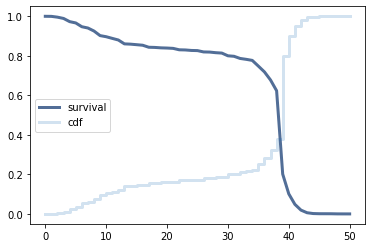

In [18]:
# Plot Cdf and SF

thinkplot.Plot(sf)
thinkplot.Cdf(cdf, alpha=0.2)
thinkplot.Config(loc='center left')

In [19]:
# Hazard Function

hf = sf.MakeHazardFunction(label='hazard')
print(hf[39])

0.6767068273092369


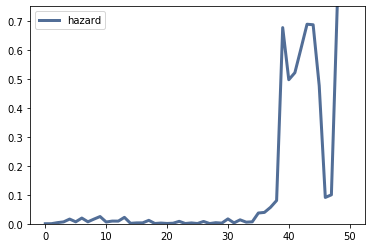

In [20]:
# meaning that of all those preg. reaching to week 39, 67% will end (give birth) at week 39

thinkplot.Plot(hf)
thinkplot.Config(ylim=[0, 0.75], loc='upper left')

## Age at first Marrige

use NSFG Data to estimate 
- hazard function and
- survival function for age at first marriage

In [21]:
# get data, clean data, convert date from century-month (15.Dec 1899) to years

resp6 = nsfg.ReadFemResp()

resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6['agemarry'] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6['age'] = (resp6.cmintvw - resp6.cmbirth) / 12.0

# extract age at first marrige (complete) and 2) age at interview who are not (ongoing)

complete = resp6[resp6.evrmarry==1].agemarry.dropna()
ongoing = resp6[resp6.evrmarry==0].age

# estimation with Kaplan-Meier (first hazard from hazard to survival)

from collections import Counter

def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


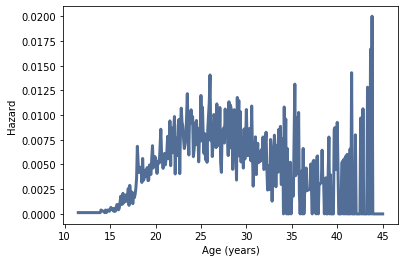

In [22]:
# Hazard Function

hf = EstimateHazardFunction(complete, ongoing)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)', ylabel= 'Hazard')



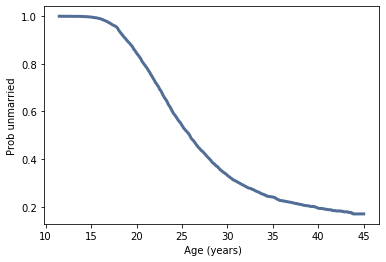

In [23]:
# Survival Function

sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel= ' Age (years)', ylabel= 'Prob unmarried')


In [24]:
# Quantifiying Uncertainty

# how much depend results on sampling error ? resampling

def EstimateMarriageSurvival(resp):
    
    # better fill missing values
    
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age
    
    hf = EstimateHazardFunction(complete, ongoing)
    
    sf = hf.MakeSurvival()
    
    return hf, sf

def ResampleSurvival(resp, iters=101):
    _, sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)
    
    
    #effect of sampling error
    
    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1/12.0)
    
    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))
        
    # calculate Percintle
    
    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='grey', label='90% CI')

C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


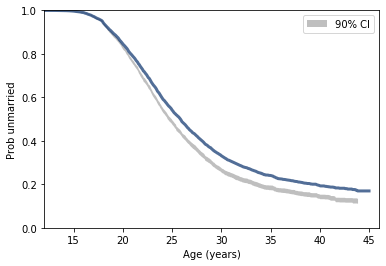

In [25]:
ResampleSurvival(resp6)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 xlim=[12, 46],
                 ylim=[0, 1],
                 loc='upper right')

# 13.8  Cohort Effect


In [26]:

# combine all data

resp5 = survival.ReadFemResp1995()
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()
resps = [resp5, resp6, resp7]

def AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = '%d0s' % name
        thinkplot.Plot([15], [1], label=label, **options)

def EstimateMarriageSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateMarriageSurvival(group)
        thinkplot.Plot(sf, **options)

def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')

        if omit:
            groups = [(name, group) for name, group in groups 
                      if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)

C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launche

C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launche

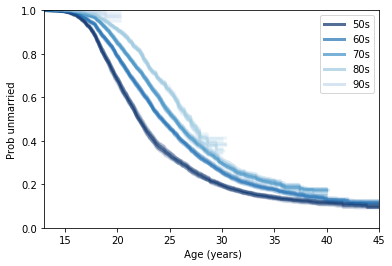

In [27]:
# results of combined data

PlotResampledByDecade(resps)
thinkplot.Config(xlabel = ' Age (years)',
                ylabel = 'Prob unmarried',
                xlim = [13, 45],
                ylim = [0, 1])



C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launche

C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launche

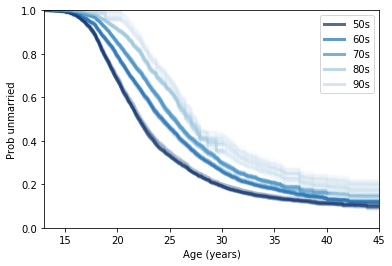

In [28]:
# 13.9 Extrapolation

# generating data for younger cohorts (borrowing data from older cohorts)
# assumption : each generation has same hazard function

def PlotPredictionsByDecade(groups, **options):
    
    hfs = []
    
    for _, group in groups:
        hf, sf = EstimateMarriageSurvival(group)
        hfs.append(hf)
    
    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i-1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

PlotResampledByDecade(resps, predict_flag=True)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 xlim=[13, 45],
                 ylim=[0, 1])

In [29]:
# 13. 10 Expected remaining Lifetime

preg = nsfg.ReadFemPreg()

complete = preg.query('outcome in [1, 3, 4]').prglngth
print('Number of complete pregnancies', len(complete))
ongoing = preg[preg.outcome == 6].prglngth
print('Number of ongoing pregnancies', len(ongoing))

hf = EstimateHazardFunction(complete, ongoing)
sf1 = hf.MakeSurvival()

Number of complete pregnancies 11189
Number of ongoing pregnancies 352


C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


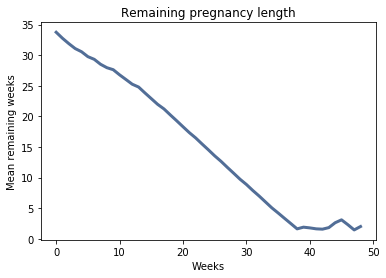

In [30]:
rem_life1 = sf1.RemainingLifetime()
thinkplot.Plot(rem_life1)
thinkplot.Config(title='Remaining pregnancy length',
                 xlabel='Weeks',
                 ylabel='Mean remaining weeks')

# chart shows remaining weeks until delivery in weeks as a function of the number of elapsed weeks
# from week 36 on the process becomes 'memoryless' - not influenced by the past

C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


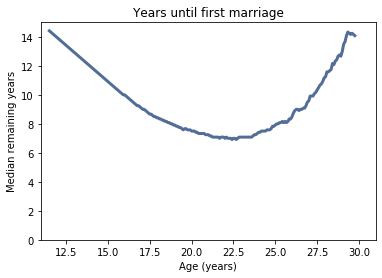

In [31]:
# Reaming years until first Marriage

hf, sf2 = EstimateMarriageSurvival(resp6)

func = lambda pmf: pmf.Percentile(50)

rem_life2 = sf2.RemainingLifetime(filler=np.inf, func=func)
    
thinkplot.Plot(rem_life2)
thinkplot.Config(title='Years until first marriage',
                 ylim=[0, 15],
                 xlim=[11, 31],
                 xlabel='Age (years)',
                 ylabel='Median remaining years')

# 13. 10 Exercise

1. Data from nsfg 6 and 7
2. duration of marriage a) ended b) ongoing
3. hf of divorce
4. sf of hf.divorce

5. Resample data to mitigate sampling error
6. plot samples to visualize sampling error

7. cohort / group by age (decade ?)
8. group by age at marriage ?


In [46]:
# 1. GET DATA
# from previous work: 'resp6' and 'resp7'

# 2. CLEAN DATA & Calculate "Ongoing" and "Completed" 

def CleanDataEx(df):
    
    #get rid of nan, 9999 and other bogus input
    df.cmdivorcx.replace([9999, 9998], np.nan, inplace=True)

    #create column entries for new data 
    df['notDivorced'] = df.cmdivorcx.isnull().astype(int)
    df['duration'] = df.cmdivorcx - df.cmmarrhx / 12.0
    df['durationStillGoing'] = df.cmintvw - df.cmmarrhx / 12.0

    month0 = pd.to_datetime('1899-12-15')
    df['birthDate'] = [month0 + pd.DateOffset(months = x) for x in df.cmbirth]
    df['decadeNew'] = (pd.DatetimeIndex(df.birthDate).year - 1900) // 10

In [48]:
CleanDataEx(resp6)
CleanDataEx(resp7)

# only those relevant that have been married

married6 = resp6[resp6.evrmarry==1]
married7 = resp7[resp7.evrmarry==1]


In [49]:
# have a loooooook first
married6.head()

,caseid,cmbirth,evrmarry,cmmarrhx,cmdivorcx,parity,finalwgt,cmintvw,agemarry,age,year,decade,fives,notDivorced,duration,durationStillGoing,datesNew,decadeNew,birthDate
1,5012,718,True,974.0,1077.0,1,4744.191350,1233,21.333333,42.916667,59,5,11,0,995.833333,1151.833333,1959-10-15,5,1959-10-15
2,11586,708,True,910.0,938.0,1,4744.191350,1234,16.833333,43.833333,58,5,11,0,862.166667,1158.166667,1958-12-15,5,1958-12-15
5,845,727,True,937.0,NaN,6,4705.681352,1234,17.500000,42.250000,60,6,12,1,NaN,1155.916667,1960-07-15,6,1960-07-15
8,8656,780,True,1003.0,NaN,3,6520.021223,1237,18.583333,38.083333,64,6,12,1,NaN,1153.416667,1964-12-15,6,1964-12-15
10,5917,714,True,953.0,NaN,2,3488.586646,1233,19.916667,43.250000,59,5,11,1,NaN,1153.583333,1959-06-15,5,1959-06-15


In [57]:
# 3 Estimate hf and sf
import thinkplot
import survival
import thinkstats2

def ResampleSurvival(resp, iters=101):
    """Resamples respondents and estimates the survival function.
    resp: DataFrame of respondents
    iters: number of resamples
    """ 
    _, sf = EstimateDivorceSurvival(resp)
    thinkplot.Plot(sf)

    low, high = resp.duration.min(), resp.durationStillGoing.max()
    ts = np.arange(low, high, 1/12.0)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateDivorceSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='gray', label='90% CI')
    
def EstimateDivorceSurvival(resp):
    """Estimates the survival curve.
    resp: DataFrame of respondents
    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    complete = resp[resp.notDivorced == 0].duration.dropna()
    ongoing = resp[resp.notDivorced == 1].durationStillGoing.dropna()

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf




C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


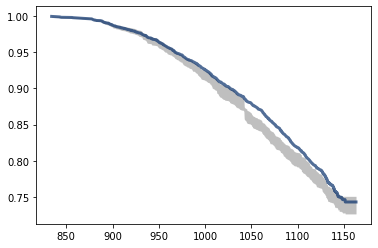

In [58]:
ResampleSurvival(married6)

In [68]:
# 7. GROUP by Decade 


def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    
    # Resample the data with weights
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        
        #relabeled the column with 'decadeNew'
        groups = sample.groupby('decadeNew')

        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        EstimateDivorceSurvivalByDecade(groups, alpha=0.2)
    
    thinkplot.Config(xlabel='Years',
                     ylabel='Fraction undivorced',
                     axis=[800, 1300, 0, 1])     

def EstimateDivorceSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateDivorceSurvival(group)
        thinkplot.Plot(sf, **options)


C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launche

C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launche

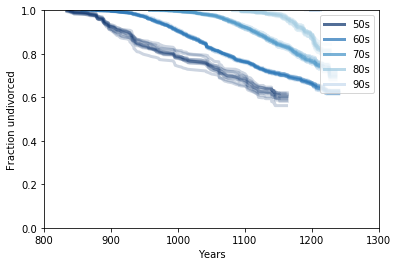

In [69]:
PlotResampledByDecade([married6, married7])